# One Hidden Layer Neural Network

We have seen how tensors work so far and how "autograd" is our handy gradient calculator. Let's try using the same toy measurement dataset from the previous "02" notebook with the simplest neural network. That is, a linear model single hidden layer with activation. We will use a `tanh` activation function since it is easy to understand.

Thinking about basis functions, linear combinations of activation functions can approximate any function.

How about trying a different optimizer like stochastic gradient descent (SGD). Before training our network, let's split the data into a training and validation set.

In [46]:
%matplotlib inline

In [122]:
from collections import OrderedDict, Counter
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

Load the data and convert them to column vectors/tensors

In [48]:
# Known Celsius temperature
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_c = torch.tensor(t_c).unsqueeze(1)

# Unknown temperature
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_u = torch.tensor(t_u).unsqueeze(1)

Split into training and validation sets.

In [49]:
n_samples = t_u.shape[0]
n_val = int(0.34 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 7,  2,  9, 10,  3,  8,  1,  6]), tensor([5, 4, 0]))

In [50]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

Redefine the training loop method to include a generalized `torch.nn.Module` model and loss function.

In [51]:
def training_loop(
    n_epochs,
    optimizer,
    model,
    loss_fn,
    t_u_train,
    t_u_val,
    t_c_train,
    t_c_val
):
    """Training loop for toy temperature data using an neural network module

    Parameters
    ----------
    n_epochs : int
        Number of iterations
    optimizer : torch.optim.Optimizer
        Optimizer class
    t_u_train : torch.Tensor
        Unknown temperature tensor for training
    t_u_val : torch.Tensor
        Target known temperature tensor for validation
    t_c_train : torch.Tensor
        Known temperature tensor for training
    t_c_val : torch.Tensor
        Known temperature tensor for validation
    Returns
    -------
    None
    """
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch < 5 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


Now let's define a neural network with named layers to help elucidate the functionality.

The number of nodes is an "art" and depends on the application. As we are using a simple NN model, the number of parameters does not need to be large. So let's pick 10. The optimizer will be SGD this time.

In [52]:
n_nodes = 10

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_nodes)),  # The Linear method required args are the number of input features, output features
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_u_train,
    t_u_val = t_u_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_u_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 241.8315, Validation loss 65.7640
Epoch 2, Training loss 235.2364, Validation loss 62.1545
Epoch 3, Training loss 228.9261, Validation loss 58.7654
Epoch 4, Training loss 222.8883, Validation loss 55.5859
Epoch 1000, Training loss 90.5009, Validation loss 49.7500
Epoch 2000, Training loss 90.5003, Validation loss 49.7502
Epoch 3000, Training loss 90.5002, Validation loss 49.7503
Epoch 4000, Training loss 90.5001, Validation loss 49.7503
Epoch 5000, Training loss 90.5001, Validation loss 49.7503
output tensor([[12.0000],
        [12.0000],
        [12.0000]], grad_fn=<AddmmBackward0>)
answer tensor([[ 8.0000],
        [11.0000],
        [ 0.5000]])
hidden tensor([[-6.5243e-04],
        [ 0.0000e+00],
        [ 2.7206e-04],
        [ 0.0000e+00],
        [-4.3902e-05],
        [ 0.0000e+00],
        [-4.9921e-03],
        [ 0.0000e+00],
        [-1.4681e-04],
        [ 0.0000e+00]])


The training and validation sets are small, so it is hard to gauge the convergence. Let's plot it

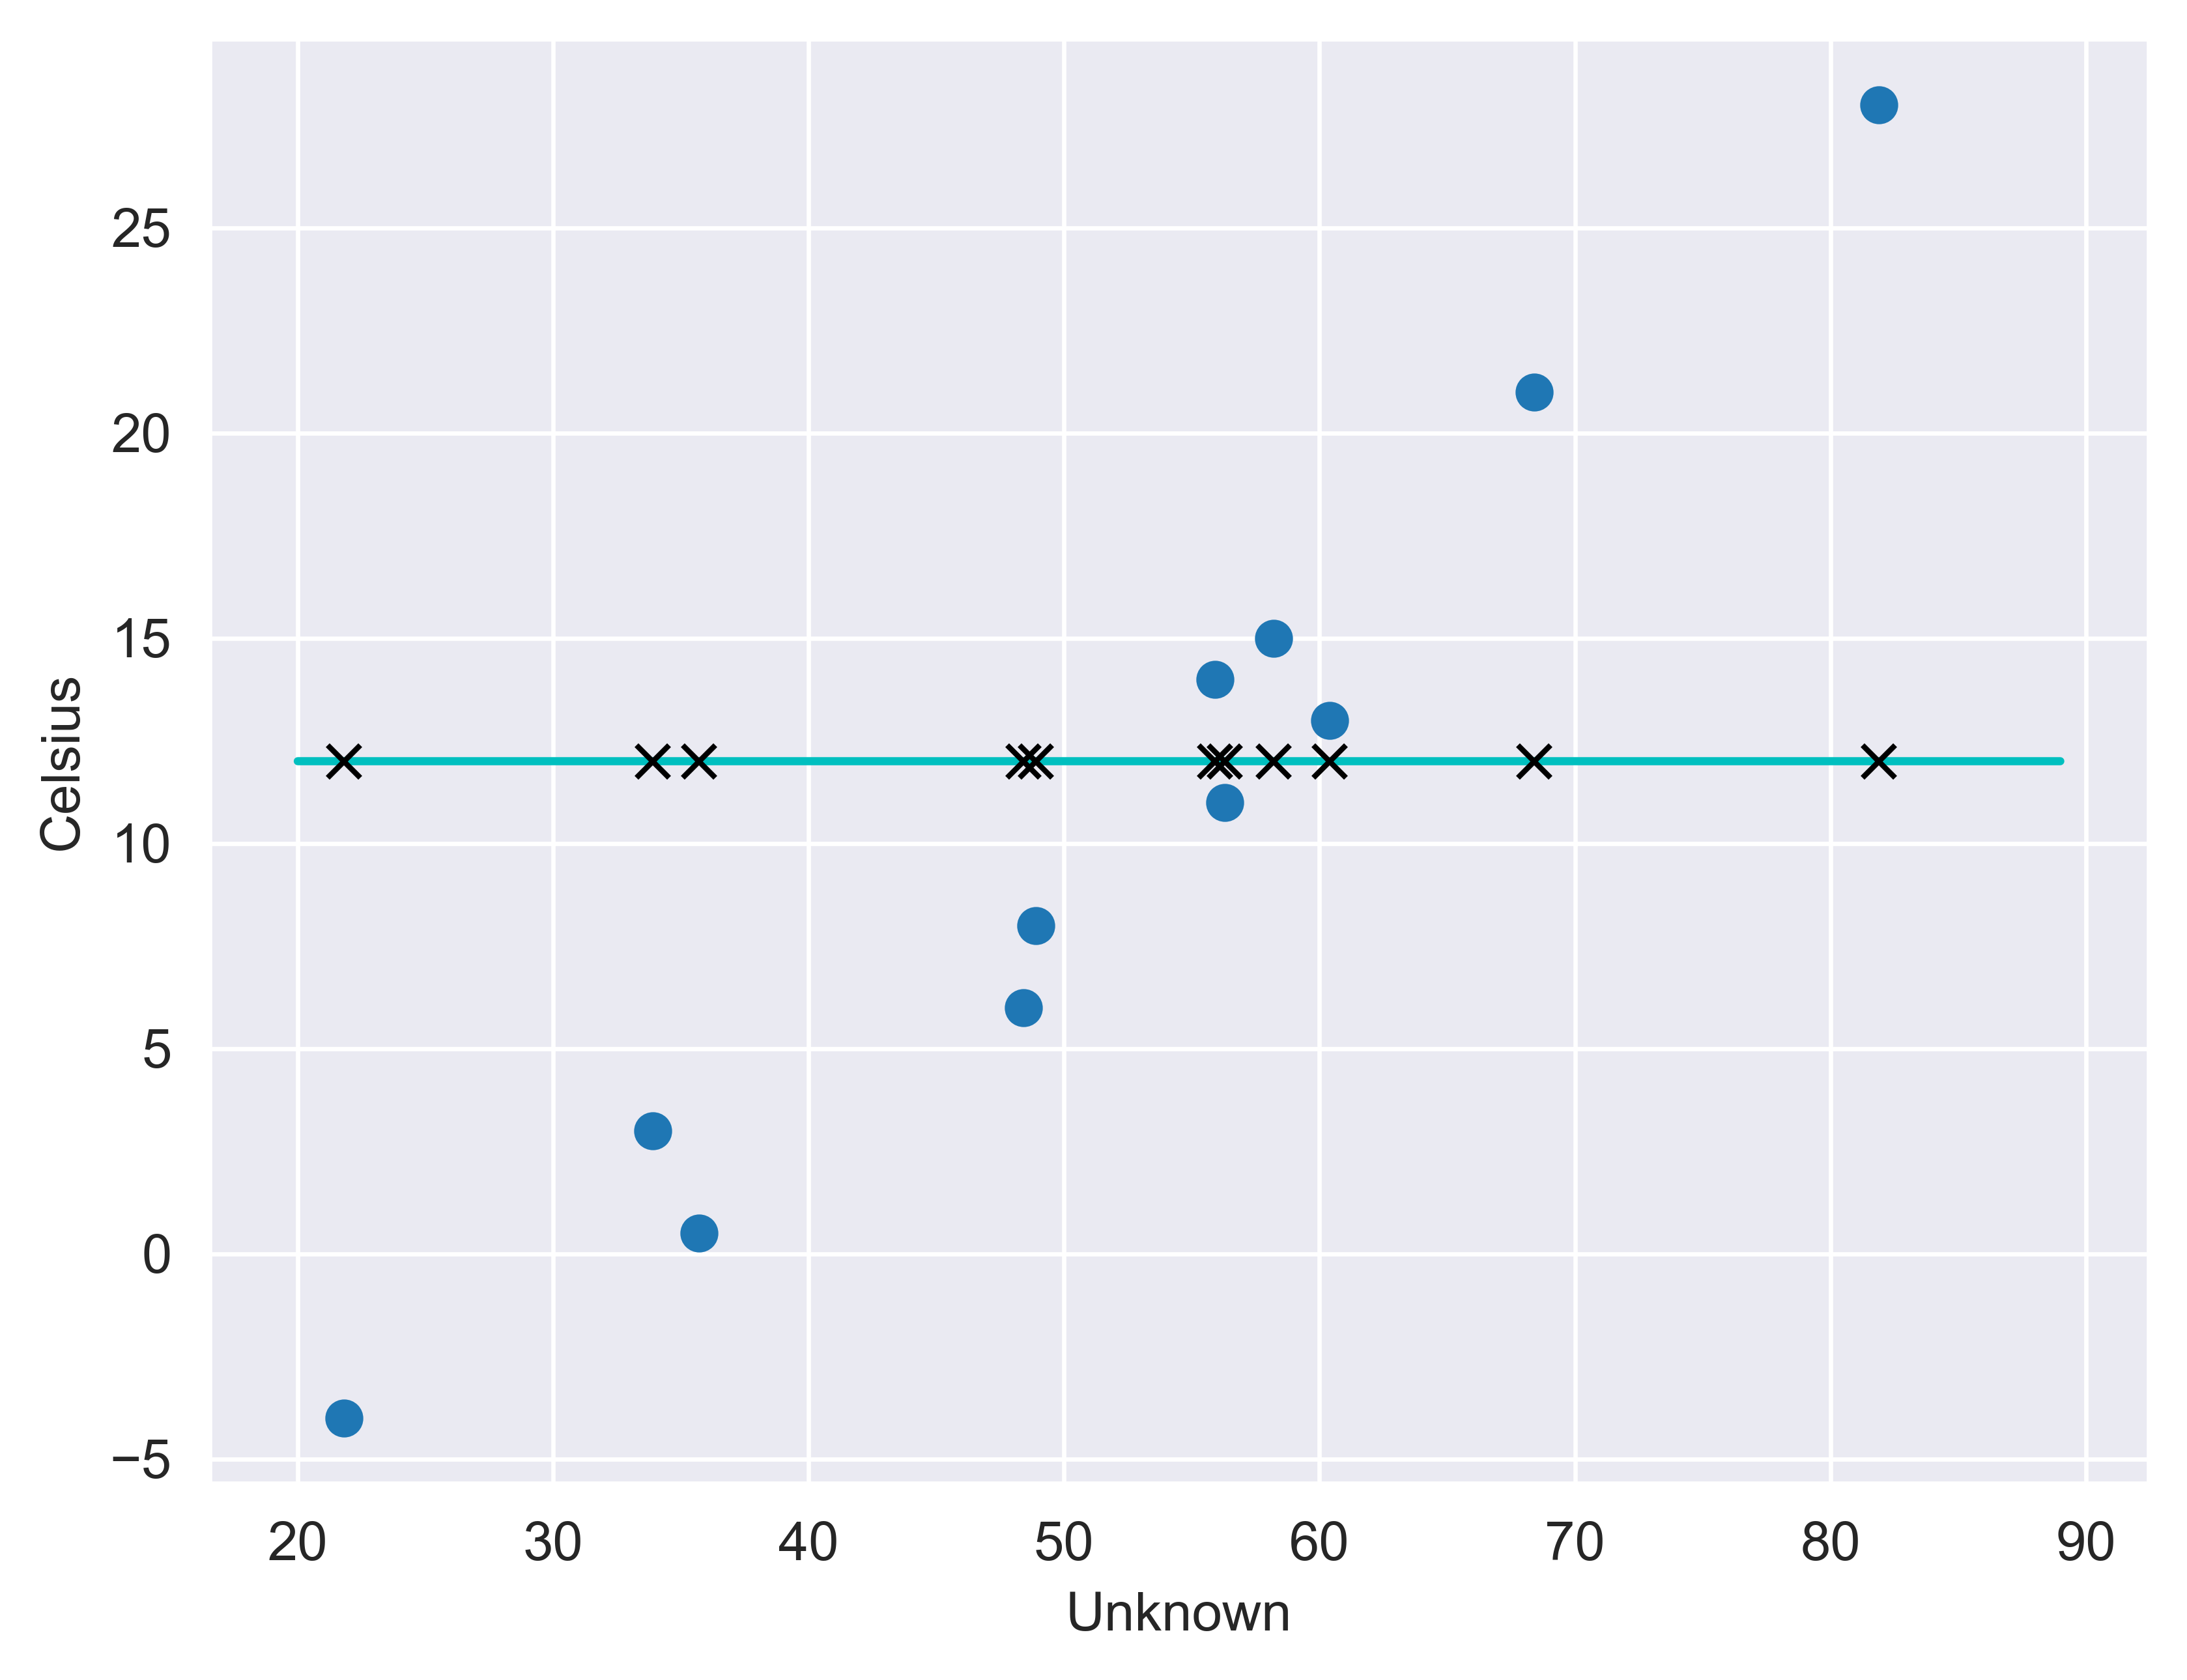

In [53]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)

# Show the inputs
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# Show the model
plt.plot(t_range.numpy(), seq_model(t_range).detach().numpy(), 'c-')
# Show where the model coincides in the horizontal axis
plt.plot(t_u.numpy(), seq_model(t_u).detach().numpy(), 'kx')

__WOAH__. The model did a awful job. Why is that?

Because we did not normalize the data range. The activation function `tanh` is saturated well above 10.

Let's normalize our unknown temperature measurements to a magnitude that is similar to $O(1)$

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=10, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=10, out_features=1, bias=True)
) torch.Size([8, 1]) torch.Size([3, 1])
Epoch 1, Training loss 238.5609, Validation loss 65.4660
Epoch 2, Training loss 231.3266, Validation loss 61.6041
Epoch 3, Training loss 224.7800, Validation loss 58.1057
Epoch 4, Training loss 218.6936, Validation loss 54.8964
Epoch 1000, Training loss 4.4292, Validation loss 3.3013
Epoch 2000, Training loss 4.3629, Validation loss 0.5361
Epoch 3000, Training loss 2.8290, Validation loss 0.8664
Epoch 4000, Training loss 2.2582, Validation loss 1.2268
Epoch 5000, Training loss 2.0816, Validation loss 1.4811
output tensor([[ 8.4920],
        [12.9397],
        [ 2.5871]], grad_fn=<AddmmBackward0>)
answer tensor([[ 8.0000],
        [11.0000],
        [ 0.5000]])
hidden tensor([[ 1.3234e+01],
        [ 3.6131e-01],
        [-4.0566e-01],
        [-1.8670e-01],
        [-1.

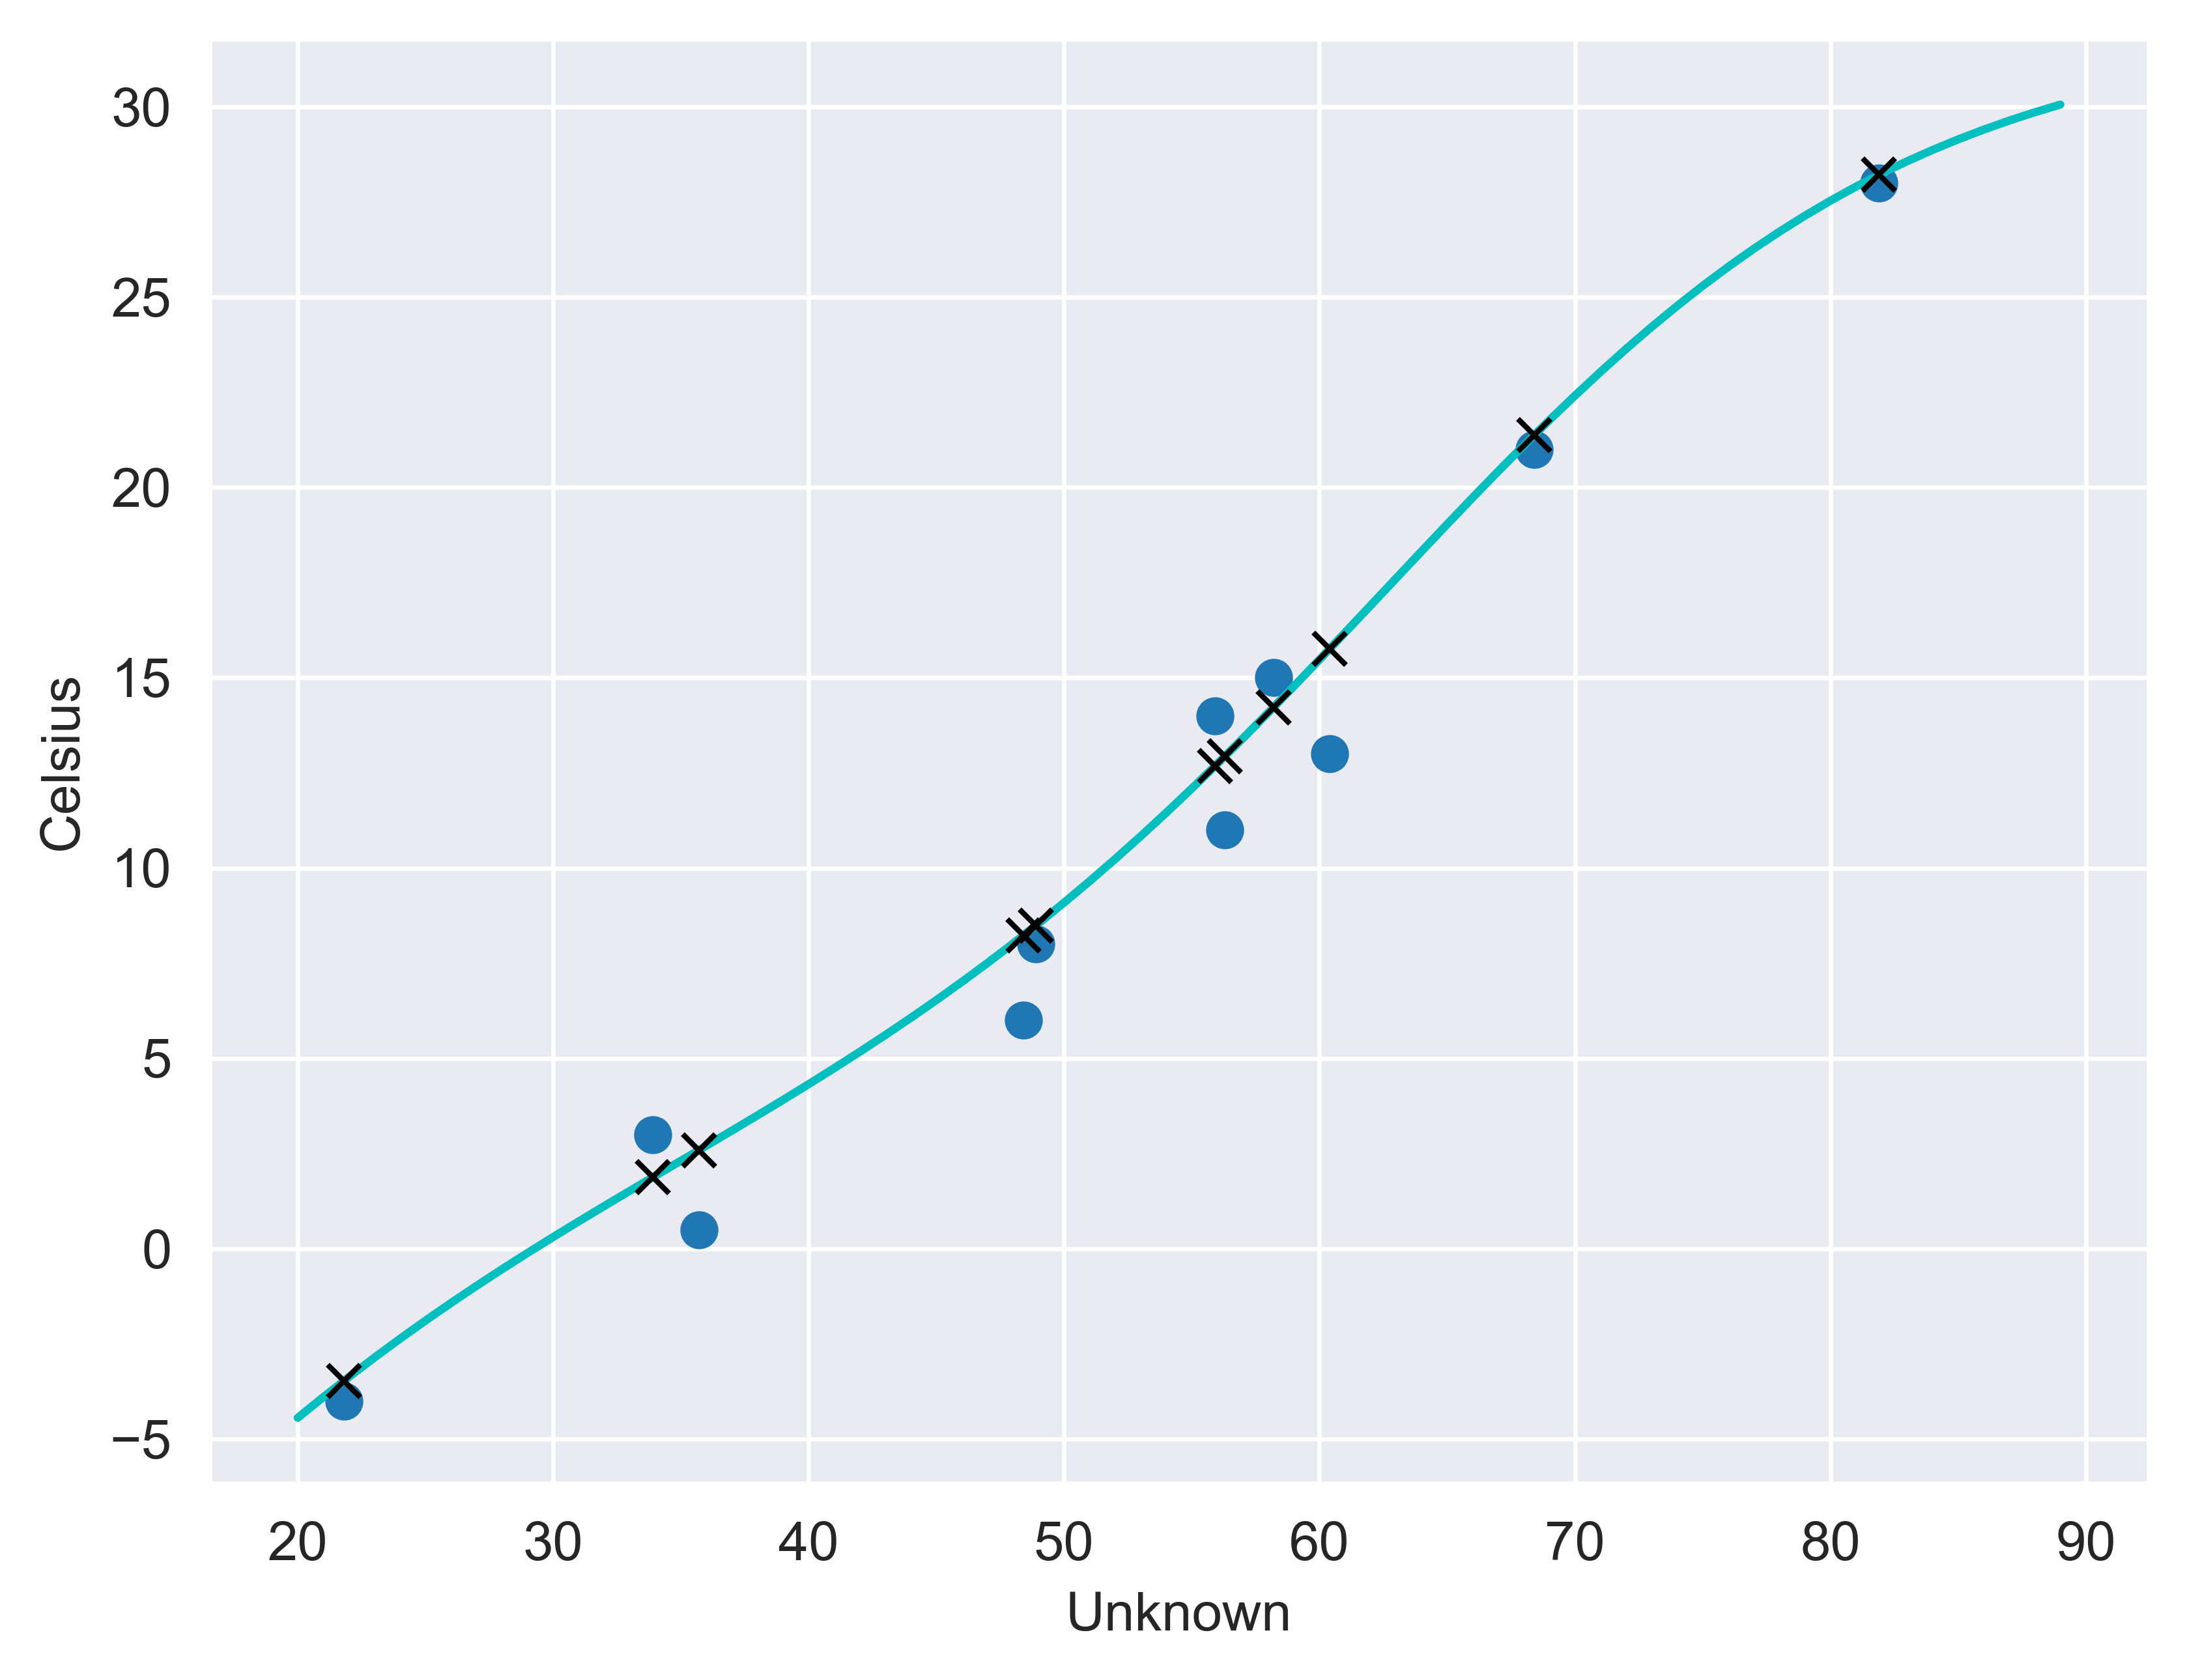

In [54]:
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_nodes)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
print(seq_model, t_un_train.shape, t_un_val.shape)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)

# Show the inputs
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# Show the model
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
# Show where the model coincides in the horizontal axis
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

Much better! The crude "normalization" above rescales the range of the input. However, we observe overfitting at the extremum points.

A better approach is to set the population with mean zero and standard deviation of 1.

In [55]:
t_u_mean, t_u_std = torch.mean(t_u.squeeze()), torch.mean(t_u.squeeze())
t_un_train = (t_u_train - t_u_mean) / t_u_std
t_un_val = (t_u_val - t_u_mean) / t_u_std

In [56]:
t_un_train.shape

torch.Size([8, 1])

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=10, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=10, out_features=1, bias=True)
) torch.Size([8, 1]) torch.Size([3, 1])
Epoch 1, Training loss 226.4465, Validation loss 56.6311
Epoch 2, Training loss 223.6700, Validation loss 55.2444
Epoch 3, Training loss 220.9427, Validation loss 53.8948
Epoch 4, Training loss 218.2626, Validation loss 52.5809
Epoch 1000, Training loss 4.6983, Validation loss 3.2195
Epoch 2000, Training loss 2.5206, Validation loss 1.8178
Epoch 3000, Training loss 2.2089, Validation loss 1.5561
Epoch 4000, Training loss 2.1399, Validation loss 1.5730
Epoch 5000, Training loss 2.1070, Validation loss 1.6382
output tensor([[ 8.2670],
        [12.5466],
        [ 2.0657]], grad_fn=<AddmmBackward0>)
answer tensor([[ 8.0000],
        [11.0000],
        [ 0.5000]])
hidden tensor([[ 0.0377],
        [ 0.0031],
        [ 0.0152],
        [-0.0096],
        [ 0.0361],
        [

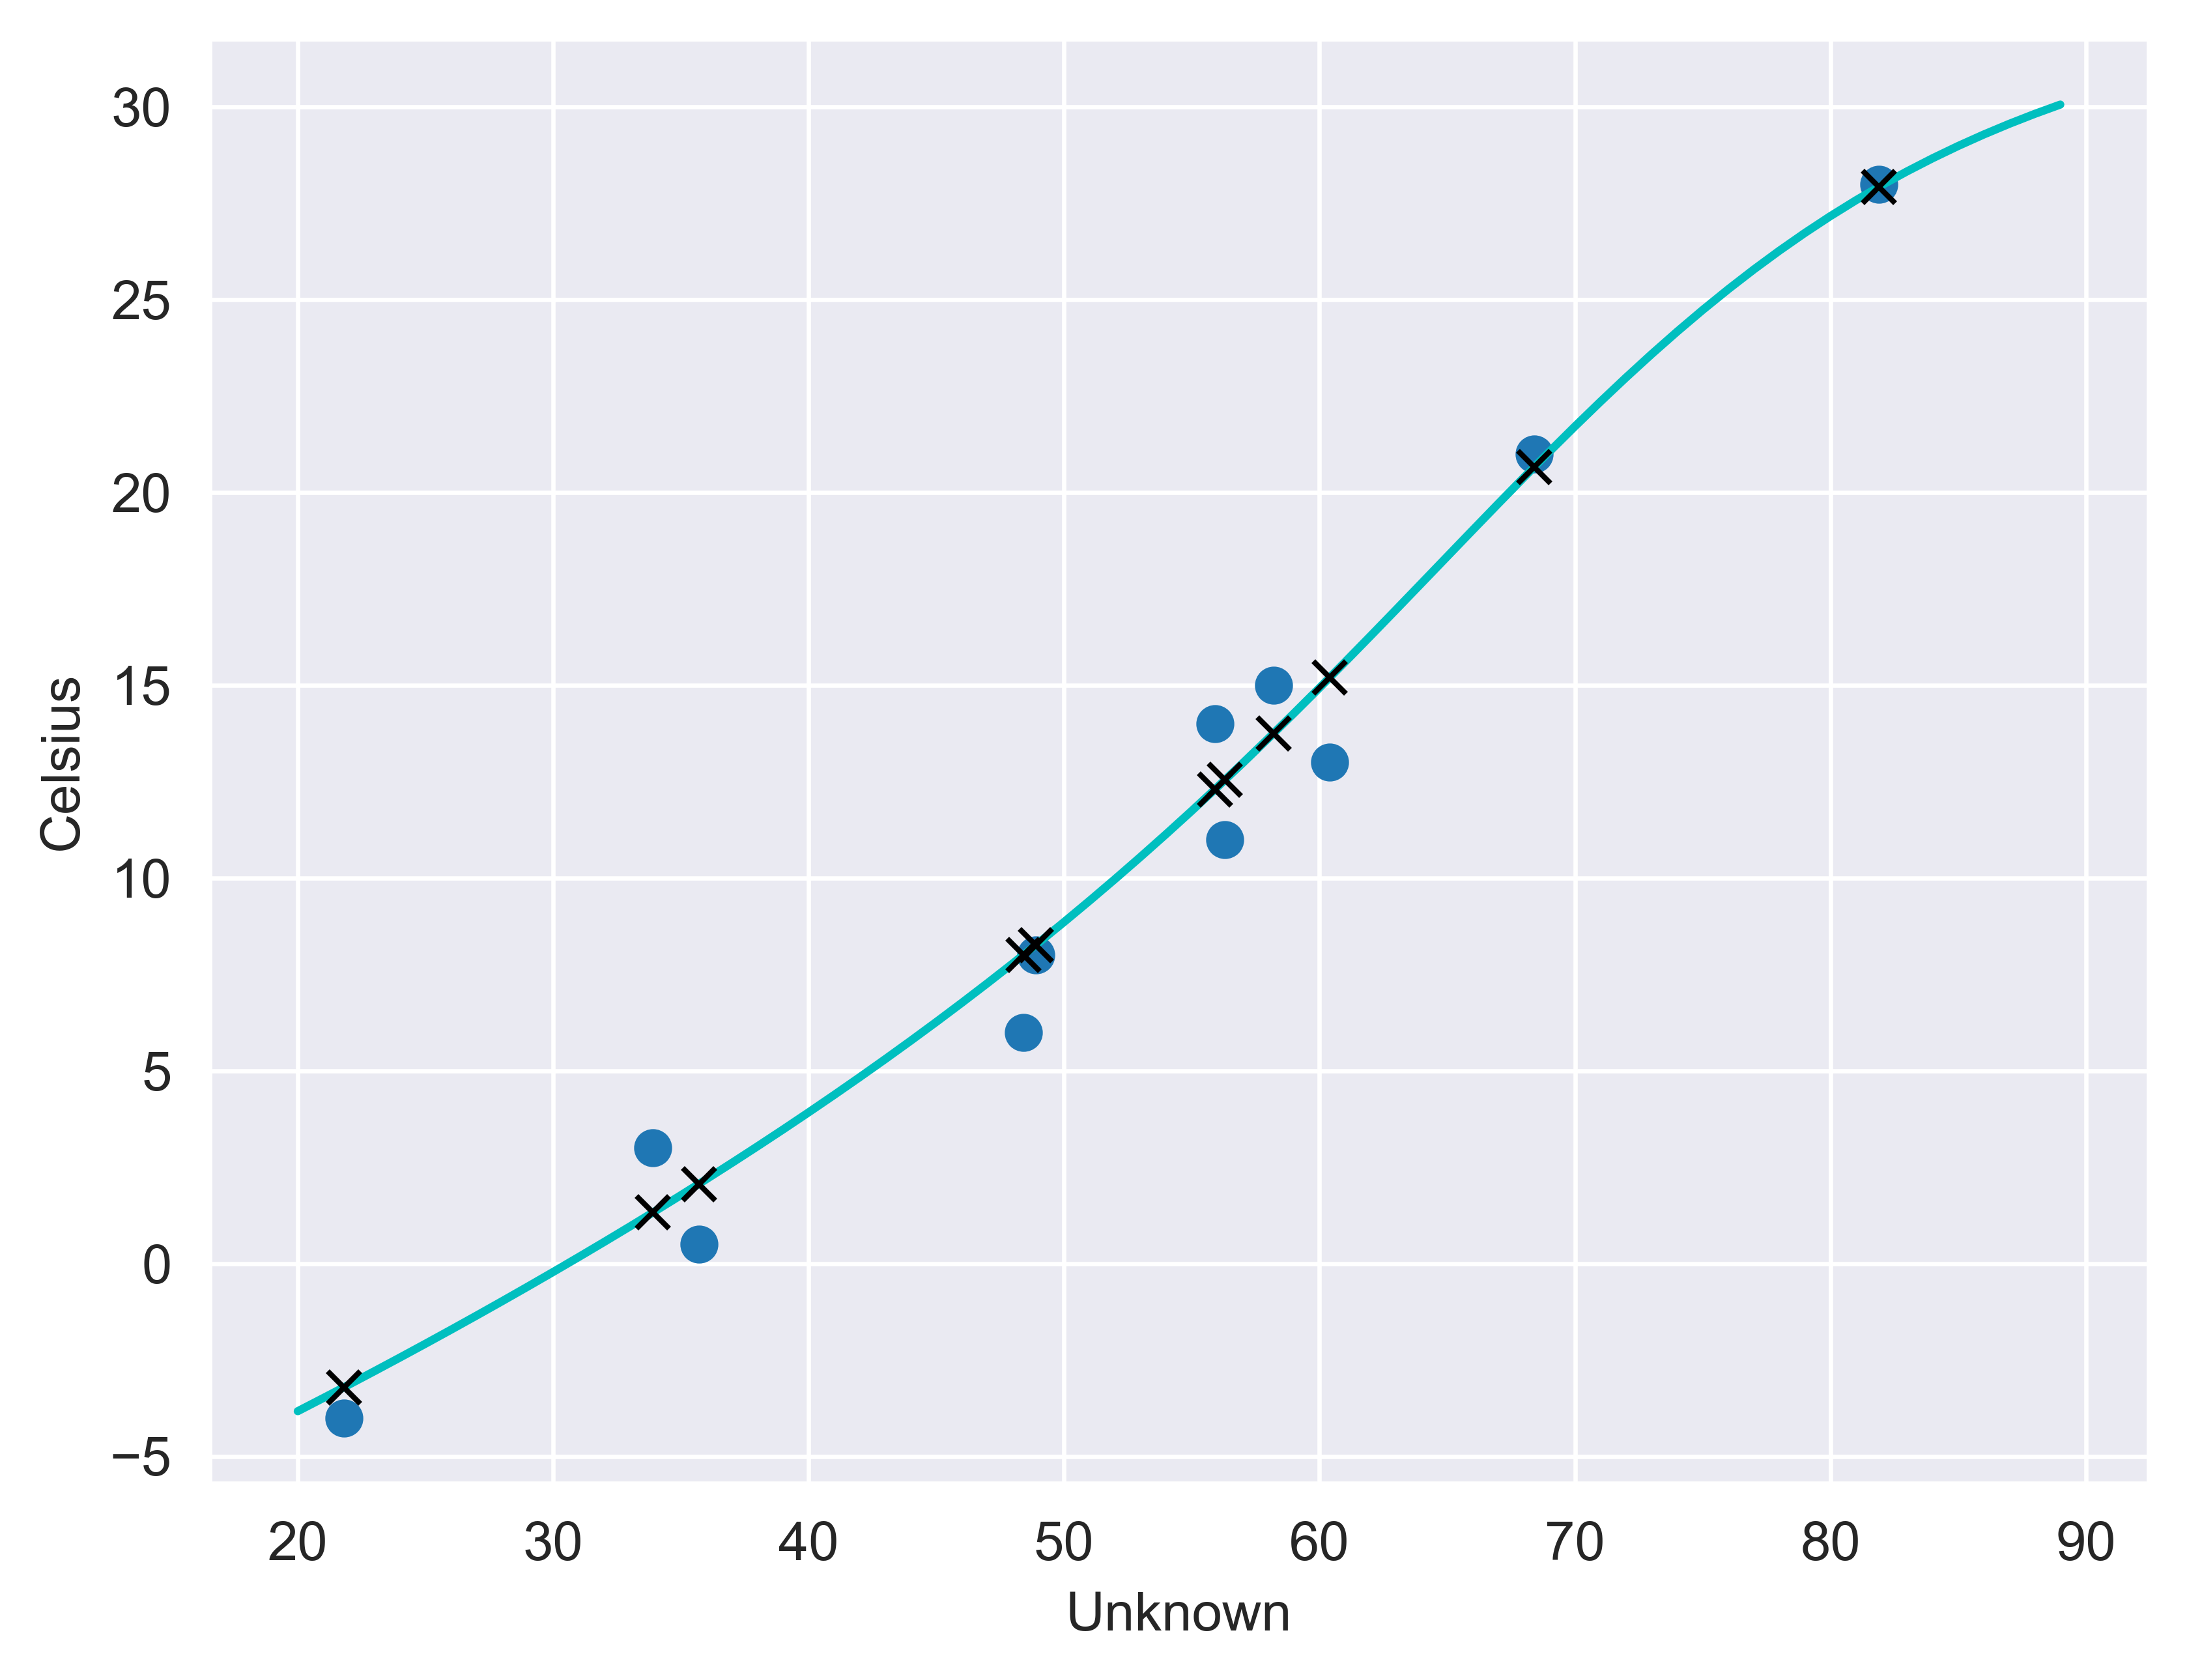

In [57]:

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_nodes)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
print(seq_model, t_un_train.shape, t_un_val.shape)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)

# Show the inputs
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# Show the model
plt.plot(t_range.numpy(), seq_model((t_range - t_u_mean) / t_u_std).detach().numpy(), 'c-')
# Show where the model coincides in the horizontal axis
plt.plot(t_u.numpy(), seq_model((t_u - t_u_mean) / t_u_std).detach().numpy(), 'kx')

Intuitively, we should feel that using a linear model is better here than using a NN. Simply put, we are overfitting using such a function. We could play with different activation functions, but that still is not useful.

We can see that the advantage and flexibility of NNs: model _almost_ any complicated function.

In [102]:
wine_file = Path("winequality-white.csv")
wine_df: pd.DataFrame = pd.read_csv(
    os.fspath(wine_file),
    sep=";",
    header=0,
    dtype=np.float32,
)

wine_t: torch.Tensor = torch.from_numpy(wine_df.to_numpy())
wine_data_t: torch.Tensor = wine_t[:, :-1]
wine_target_t: torch.Tensor = wine_t[:, -1].long()

wine_target_1h_t: torch.Tensor = torch.zeros(wine_target_t.shape[0], 11)
wine_target_1h_t.scatter_(1, wine_target_t.unsqueeze(1), 1.0)

wine_data_norm_t: torch.Tensor = torch.zeros(wine_data_t.shape, dtype=torch.float32)
column_means_t: torch.Tensor = torch.mean(wine_data_t, dim=1)
column_stds_t: torch.Tensor = torch.std(wine_data_t, dim=1)

for col in range(wine_data_t.shape[1]):
    wine_data_mean, wine_data_std = column_means_t[col], column_stds_t[col]
    wine_data_norm_t[:, col] = (wine_data_t[:, col] - wine_data_mean) / wine_data_std


In [103]:
column_means_t

tensor([23.3296, 15.3521, 14.3205,  ..., 14.8194, 14.0655, 13.0709])

In [91]:
n_samples = wine_data_norm_t.shape[0]
n_val = int(0.34 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

wine_data_train_t = wine_data_norm_t[train_indices]
wine_data_val_t = wine_data_norm_t[val_indices]

wine_target_train_t = wine_target_1h_t[train_indices]
wine_target_val_t = wine_target_1h_t[val_indices]

wine_data_train_t.unsqueeze_(1)
wine_data_val_t.unsqueeze_(1)
wine_target_train_t.unsqueeze_(1)
wine_target_val_t.unsqueeze_(1)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])

In [92]:
len(wine_df.columns), wine_data_train_t.shape, wine_target_train_t.shape

(12, torch.Size([3233, 1, 11]), torch.Size([3233, 1, 11]))

It is a coincidence that there are 11 columns in both data and target. There are 12 columns in the file and we are using one of them as the target. The quality target is bounded between 0 and 10, being 11 total.

In [93]:
wine_data_train_t[0]

tensor([[ 0.7646, -0.6770,  0.0480, -1.0235,  0.6512, -0.5473, -0.6438, -0.3101,
          2.1307, -0.1739,  0.1509]])

In [95]:
n_nodes = 10 * wine_data_train_t.shape[2]

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(wine_data_train_t.shape[2], n_nodes)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, wine_target_train_t.shape[2]))
]))

optimizer = optim.Adam(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = wine_data_train_t,
    t_u_val = wine_data_val_t,
    t_c_train = wine_target_train_t,
    t_c_val = wine_target_val_t)

Epoch 1, Training loss 0.1901, Validation loss 0.1872
Epoch 2, Training loss 0.1776, Validation loss 0.1748
Epoch 3, Training loss 0.1661, Validation loss 0.1634
Epoch 4, Training loss 0.1555, Validation loss 0.1529
Epoch 1000, Training loss 0.0471, Validation loss 0.0528
Epoch 2000, Training loss 0.0396, Validation loss 0.0564
Epoch 3000, Training loss 0.0334, Validation loss 0.0641
Epoch 4000, Training loss 0.0302, Validation loss 0.0682
Epoch 5000, Training loss 0.0284, Validation loss 0.0714


OK. Looks like our model did not quite converge, but that is OK. What are the results?

In [125]:
# Prediction minus target counter
pred_target_diffs = [
    torch.argmax(seq_model(wine_data_val_t[i])).item()  # prediction
    - torch.argmax(wine_target_val_t[i]).item()         # taget
    for i in range(wine_data_val_t.shape[0])
]
counts = Counter(pred_target_diffs)

for diff, count in counts.items():
    per = count / wine_data_val_t.shape[0] * 100
    print(f"{diff} count = {count} ({per:.2f}%)")


0 count = 944 (56.70%)
1 count = 279 (16.76%)
-1 count = 318 (19.10%)
2 count = 49 (2.94%)
-2 count = 57 (3.42%)
-3 count = 7 (0.42%)
3 count = 11 (0.66%)


So about 56% of the time, we get the answer right, 35% is off by one, 6% off by two, 1% off by three. Not bad!

Does a data visualization help with this?

Text(0, 0.5, 'Counts')

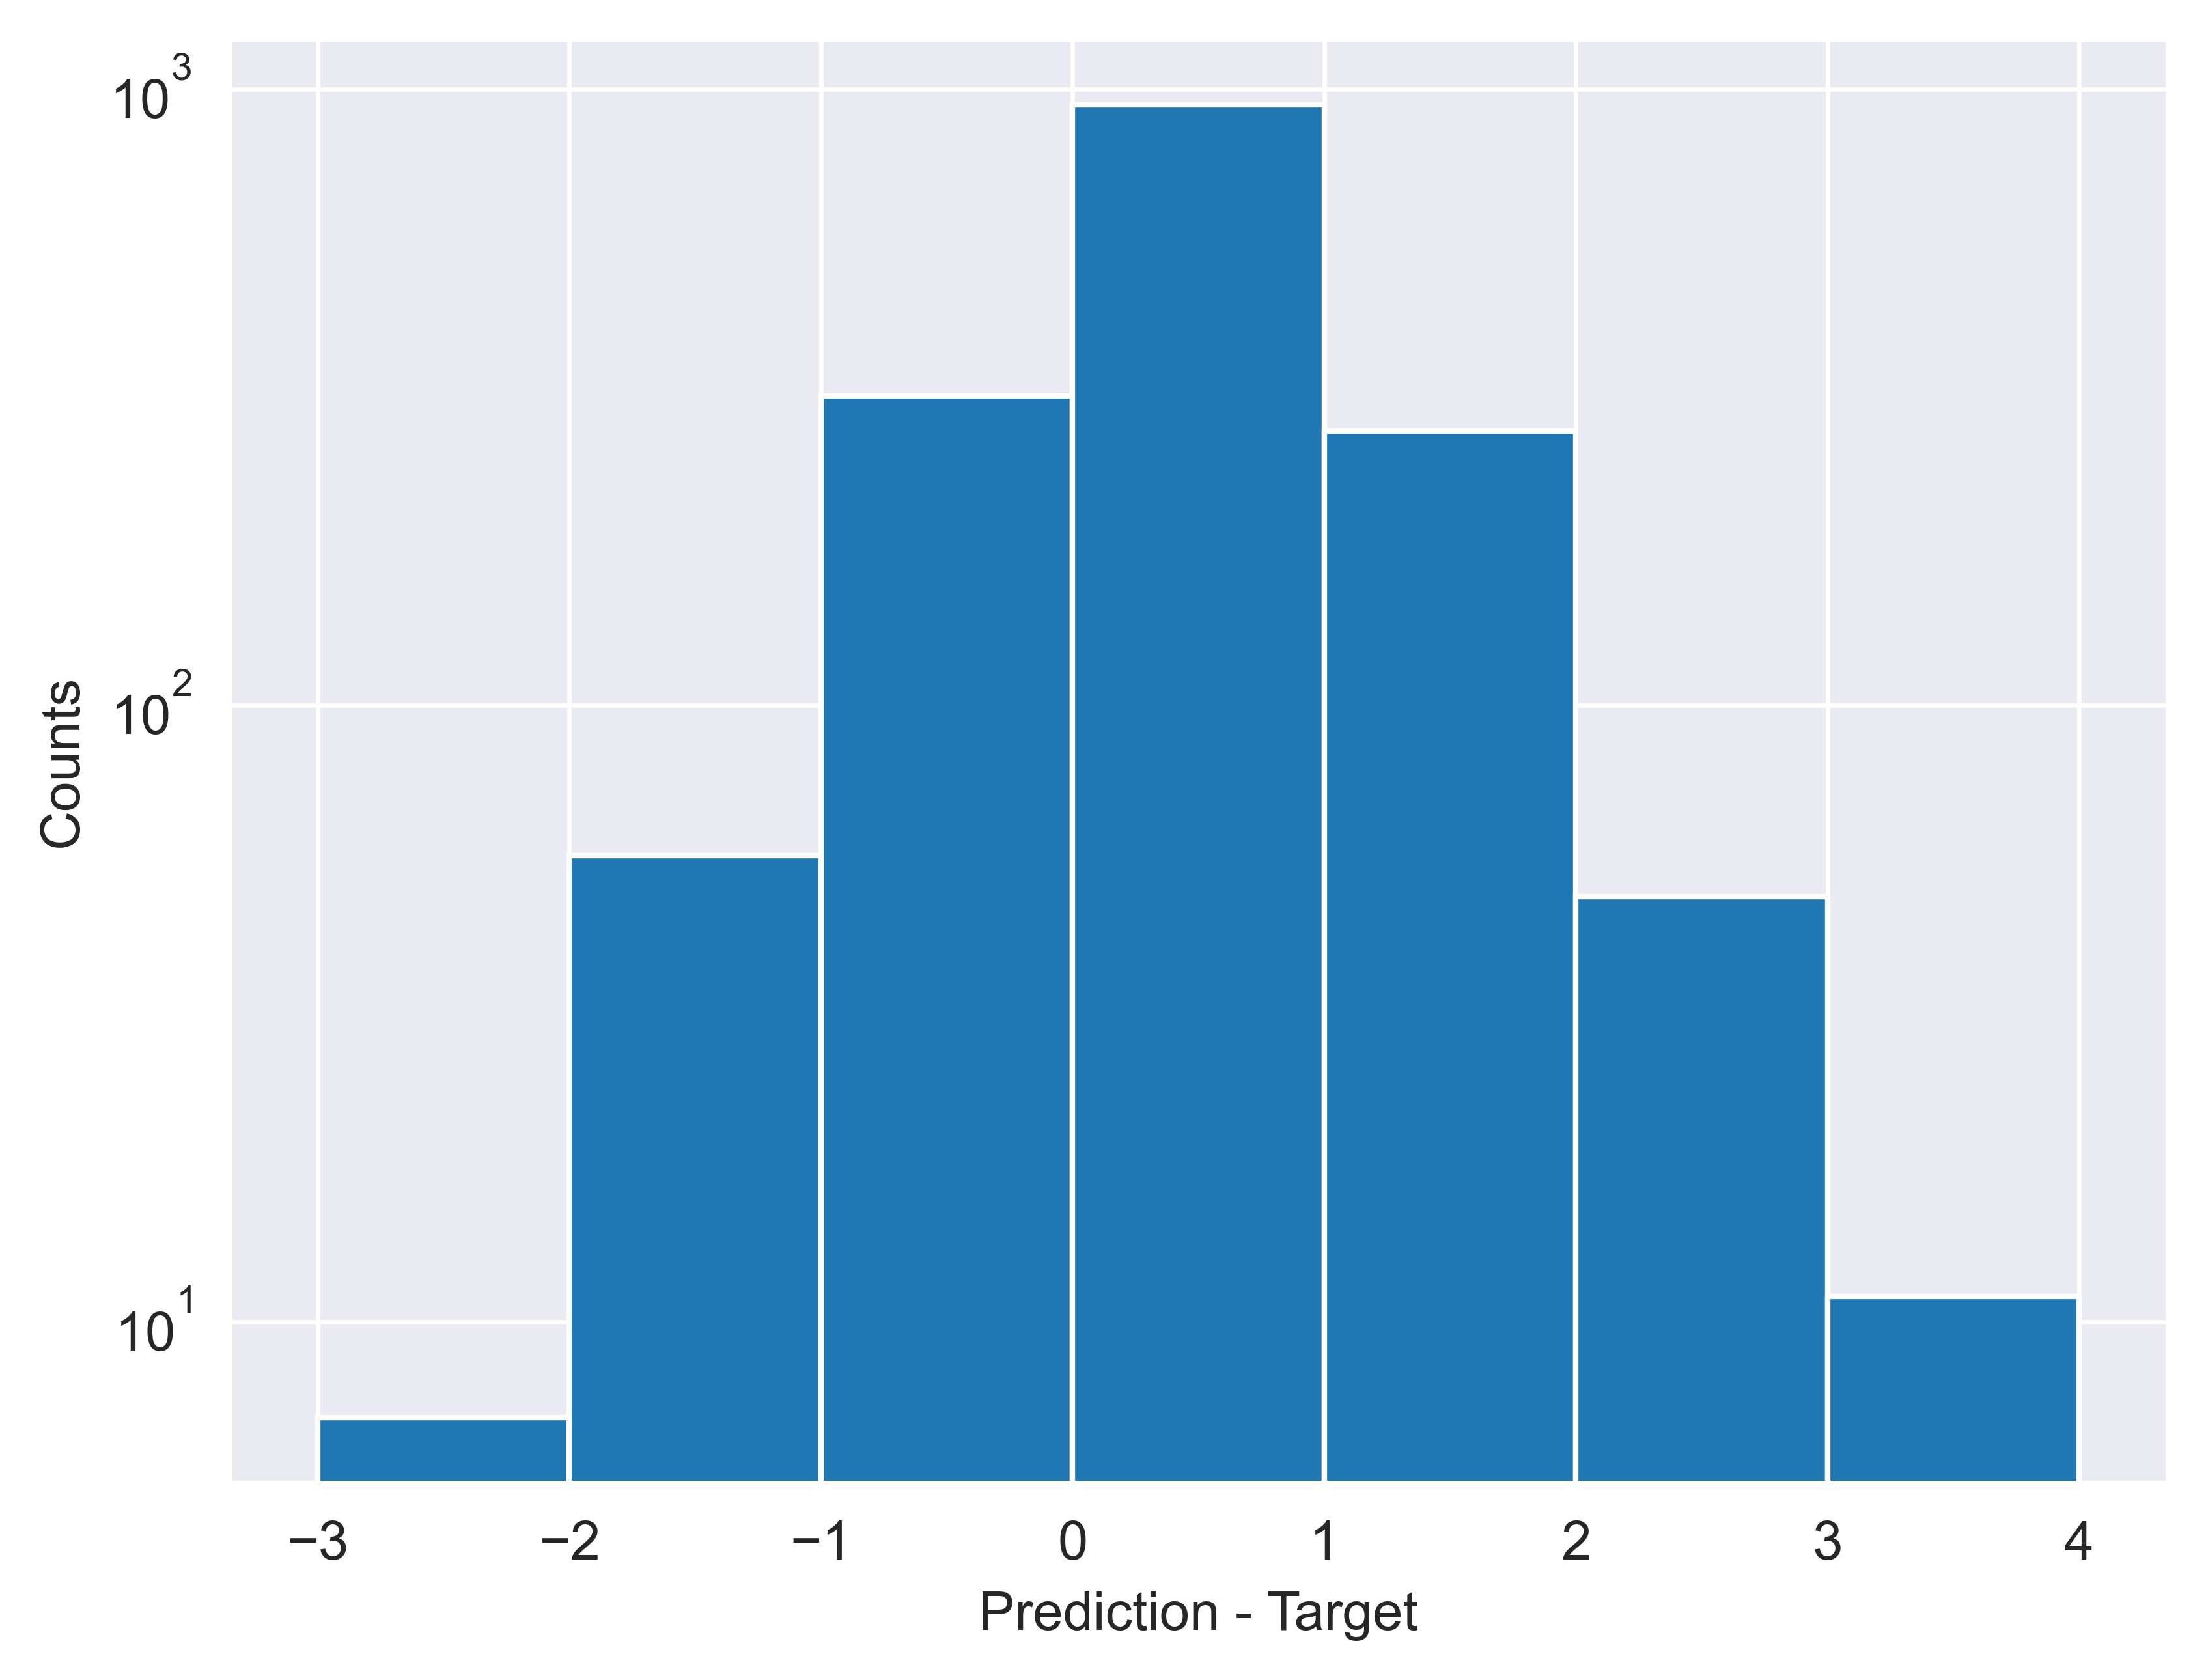

In [134]:
fig_hist, ax_hist = plt.subplots(dpi=600)

ax_hist: plt.Axes
bins = sorted(counts.keys())
bins.append(bins[-1]+1)
ax_hist.hist(
    pred_target_diffs,
    bins,
    log=True
)
ax_hist.set_xlabel("Prediction - Target")
ax_hist.set_ylabel("Counts")

Since the data is 11-dim, it is hard to plot the data versus target.